In [1]:
import os
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from convlocal import Dense_conv,My_UCNN
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv(os.getcwd()+'/data/data.csv', index_col=0, header=0)


In [2]:
torch.cuda.empty_cache()

In [ ]:
data.head()

In [ ]:
data = data.values

In [ ]:
data[:43824].shape

In [ ]:
torch.tensor(data[0, -1]).unsqueeze(axis=0).shape

In [ ]:
torch.tensor(data[0, :-1]).unsqueeze(axis=1)

In [3]:
class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, train:bool=True):
        super(LoadDataset, self).__init__()
        self.train = train # 判断是训练集合还是测试集合
        self.data = data = pd.read_csv(os.getcwd()+'/data/data.csv', index_col=0, header=0).values
        self.train_len = 43824
        self.valid_len = 8784
        self.train_data = self.data[:43824]
        self.valid_data = self.data[43824:]
    
    def __len__(self):
        if self.train:
            return self.train_len
        else:
            return self.valid_len
        
    def __getitem__(self,idx):
        if self.train:
            x = torch.tensor(self.train_data[idx, :-1]).unsqueeze(axis=1)  # 训练样本数据格式为[8, 1]
            y = torch.tensor(self.train_data[idx,  -1]).unsqueeze(axis=0)  #     样本数据格式为[1]
        else:
            x = torch.tensor(self.valid_data[idx, :-1]).unsqueeze(axis=1)  # 测试样本数据格式为[8, 1]
            y = torch.tensor(self.valid_data[idx,  -1]).unsqueeze(axis=0)  #     样本数据格式为[1]
        return (x,y)

In [4]:
batch_size = 512+128
# 训练集
trainDataset = LoadDataset(train=True)
train_generator = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size,shuffle=True)
# 验证集
validDataset = LoadDataset(train=False)
valid_generator = torch.utils.data.DataLoader(dataset=validDataset, batch_size=batch_size,shuffle=True)

In [ ]:
# test
for x,y in train_generator:
    print(f'x.shape:{x.shape},y.shape:{y.shape}')
    # print(x,y)
    break

In [ ]:
# test
model_dense_block = Dense_conv(1,8)
x = torch.randn(128,1,8,1)
print(f'x.shape:{x.shape}')
Y_hat = model_dense_block(x)

In [5]:
model = My_UCNN().double().to(DEVICE)
loss_func = nn.MSELoss(reduction='sum')
optim = optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

My_UCNN(
  (con1): Sequential(
    (0): Dense_conv(
      (unshared_conv_first): Conv1dLocal(1, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (unshared_conv_after): Conv1dLocal(8, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (batchnorm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Dense_conv(
      (unshared_conv_first): Conv1dLocal(8, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (unshared_conv_after): Conv1dLocal(16, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dense_conv(
      (unshared_conv_first): Conv1dLocal(16, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (unshared_conv_after): Conv1dLocal(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
# test
train_sample_num = 0
ls = 0  

for X,Y in train_generator:
        # Perform the forward pass operation
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        Y_hat = model(X)
        # Backpropagate the errors through the network
        loss = loss_func(Y_hat, Y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
        train_sample_num += X.shape[0] # calculate the total train samplt
        ls += loss.item()              # calculate the total train error
        break

In [ ]:
Y_hat.shape,Y.shape

In [ ]:
plt.plot(Y_hat.cpu().detach().numpy(),label='y_hat')
plt.plot(Y.cpu().detach().numpy(),label='y')
plt.legend()

epoch: 0, train_loss:0.260583074506723 valid_loss:0.11184499535995955
epoch: 5, train_loss:0.07472405283717402 valid_loss:0.08246397041301275
epoch: 10, train_loss:0.06523846263150261 valid_loss:0.0713862616387802
epoch: 15, train_loss:0.061077133227501405 valid_loss:0.07758898470719025
epoch: 20, train_loss:0.06086499578963178 valid_loss:0.07257603840494177
epoch: 25, train_loss:0.05429209941201695 valid_loss:0.071088327372045
epoch: 30, train_loss:0.05390448199564824 valid_loss:0.08022787682840096
epoch: 35, train_loss:0.05211444156762468 valid_loss:0.0727360040542385


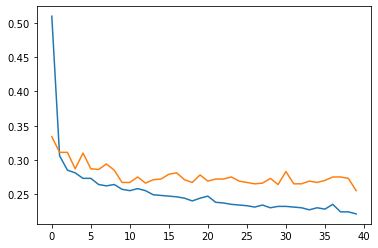

In [6]:
num_epochs = 40
train_losses = []
valid_losses = []
for epoch in range(0,num_epochs):
    
    train_sample_num = 0 # the sum of the train_set
    valid_sample_num = 0 # the sum of the valid_set
    ls = 0         # loss of train_set
    valid_ls = 0   # loss of valid_set
    # training
    for X,Y in train_generator:
        # Perform the forward pass operation
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        Y_hat = model(X)
        # Backpropagate the errors through the network
        loss = loss_func(Y_hat,Y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
        train_sample_num += X.shape[0] # calculate the total train samplt
        ls += loss.item()        # calculate the total train error
    ls = ls / train_sample_num
    # validing
    for valid_x, valid_y in valid_generator:
        # Perform the forward pass operation
        valid_x = valid_x.to(DEVICE)
        valid_y = valid_y.to(DEVICE)
        valid_y_hat = model.predict(valid_x)
        vloss = loss_func(valid_y_hat,valid_y)
        
        valid_sample_num += valid_x.shape[0]       
        
        valid_ls += vloss.item()        # calculate the total train error
    valid_ls = valid_ls / valid_sample_num
    
    
    if epoch % 5 == 0:
        print(f'epoch: {epoch}, train_loss:{ls} valid_loss:{valid_ls}')
    # rmse   
    rmse = lambda x: round(np.sqrt(x * 1.000), 3)
    train_losses.append(rmse(ls))
    valid_losses.append(rmse(valid_ls))  
# plot the loss
plt.plot(train_losses)
plt.plot(valid_losses)

In [11]:
# test 
testDataset = LoadDataset(train=True)
test_generator = torch.utils.data.DataLoader(dataset=testDataset, batch_size=1000,shuffle=False)
for test_x, test_y in test_generator:
    # Perform the forward pass operation
    test_x = test_x.to(DEVICE)
    test_y = test_y.to(DEVICE)
    test_y_hat = model.predict(test_x)
    loss = loss_func(test_y_hat,test_y)
    break
loss = loss/test_x.shape[0]
print(f'loss:{loss}')

loss:0.11736916927337626


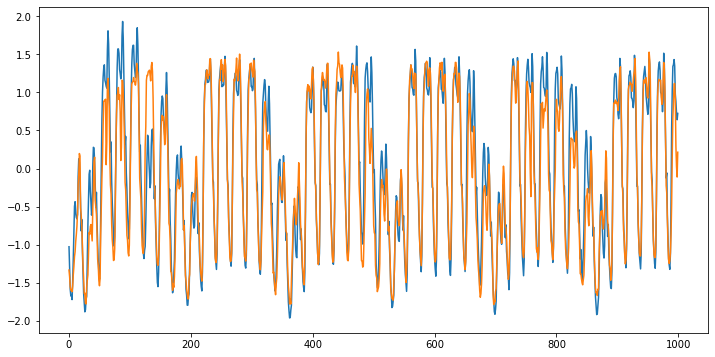

In [14]:
plt.figure(figsize=(12,6))
plt.plot(test_y.cpu().detach().numpy())
plt.plot(test_y_hat.cpu().detach().numpy())